# Challenge 2: Sentiment Analysis

In this challenge we will learn sentiment analysis and practice performing sentiment analysis on Twitter tweets. 

## Introduction

Sentiment analysis is to *systematically identify, extract, quantify, and study affective states and subjective information* based on texts ([reference](https://en.wikipedia.org/wiki/Sentiment_analysis)). In simple words, it's to understand whether a person is happy or unhappy in producing the piece of text. Why we (or rather, companies) care about sentiment in texts? It's because by understanding the sentiments in texts, we will be able to know if our customers are happy or unhappy about our products and services. If they are unhappy, the subsequent action is to figure out what have caused the unhappiness and make improvements.

Basic sentiment analysis only understands the *positive* or *negative* (sometimes *neutral* too) polarities of the sentiment. More advanced sentiment analysis will also consider dimensions such as agreement, subjectivity, confidence, irony, and so on. In this challenge we will conduct the basic positive vs negative sentiment analysis based on real Twitter tweets.

NLTK comes with a [sentiment analysis package](https://www.nltk.org/api/nltk.sentiment.html). This package is great for dummies to perform sentiment analysis because it requires only the textual data to make predictions. For example:

```python
>>> from nltk.sentiment.vader import SentimentIntensityAnalyzer
>>> txt = "Ironhack is a Global Tech School ranked num 2 worldwide.   Our mission is to help people transform their careers and join a thriving community of tech professionals that love what they do."
>>> analyzer = SentimentIntensityAnalyzer()
>>> analyzer.polarity_scores(txt)
{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.8442}
```

In this challenge, however, you will not use NLTK's sentiment analysis package because in your Machine Learning training in the past 2 weeks you have learned how to make predictions more accurate than that. The [tweets data](https://www.kaggle.com/kazanova/sentiment140) we will be using today are already coded for the positive/negative sentiment. You will be able to use the Naïve Bayes classifier you learned in the lesson to predict the sentiment of tweets based on the labels.

## Conducting Sentiment Analysis

### Loading and Exploring Data

The dataset we'll be using today is located in the lab directory named `Sentiment140.csv.zip`. You need to unzip it into a `.csv` file. Then in the cell below, load and explore the data.

*Notes:* 

* The dataset was downloaded from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). We made a slight change on the original data so that each column has a label.

* The dataset is huuuuge (1.6m tweets). When you develop your data analysis codes, you can sample a subset of the data (e.g. 20k records) so that you will save a lot of time when you test your codes.

In [1]:
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import functools
from wordcloud import WordCloud
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
# your code here
tweets = pd.read_csv('../data/Sentiment140.csv')

In [3]:
tweets_sample = tweets.sample(n = 20000, random_state = 42)

In [4]:
# Cleaning and processing text functions

def clean_up(s):
    # remove web address
    web_sub = re.sub("http\S+", " ", s.lower())
    # remove special chars and digits
    dig_sub = re.sub("[^a-zA-Z]", " ", web_sub)
    # remove single characters
    return re.sub(r'\b\w{1,1}\b', '', dig_sub)

def tokenize(s):
    return nltk.word_tokenize(s)

def stem_and_lemmatize(l):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    porter_bag_of_words = [stemmer.stem(word) for word in l]
    return [lemmatizer.lemmatize(word) for word in porter_bag_of_words]

def remove_stopwords(l,stop_words):
    return [word for word in l if word not in stop_words]

# Apply all the functions together

def bag_of_words(s,stop_words):
    
    clean_text = clean_up(s)
    token_text = tokenize(clean_text)
    stopw_text = remove_stopwords(token_text,stop_words)
    lemma_text = stem_and_lemmatize(stopw_text)

    return lemma_text


### Prepare Textual Data for Sentiment Analysis

Now, apply the functions you have written in Challenge 1 to your whole data set. These functions include:

* `clean_up()`

* `tokenize()`

* `stem_and_lemmatize()`

* `remove_stopwords()`

Create a new column called `text_processed` in the dataframe to contain the processed data. At the end, your `text_processed` column should contain lists of word tokens that are cleaned up. Your data should look like below:

![Processed Data](../images/data-cleaning-results.png)

In [5]:
# your code here
stop_words = stopwords.words('english')

list_words = list(map(functools.partial(bag_of_words,stop_words=stop_words), tweets_sample.text))


In [6]:
tweets_sample['text_processed'] = list_words
tweets_sample.head()

,target,id,date,flag,user,text,text_processed
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,"[chrishasboob, ahhh, hope, ok]"
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...","[misstoriblack, cool, tweet, app, razr]"
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,"[tiannachao, know, famili, drama, lame, hey, n..."
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,"[school, email, open, geographi, stuff, revis,..."
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,"[upper, airway, problem]"


### Creating Bag of Words

The purpose of this step is to create a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) from the processed data. The bag of words contains all the unique words in your whole text body (a.k.a. *corpus*) with the number of occurrence of each word. It will allow you to understand which words are the most important features across the whole corpus.

Also, you can imagine you will have a massive set of words. The less important words (i.e. those of very low number of occurrence) do not contribute much to the sentiment. Therefore, you only need to use the most important words to build your feature set in the next step. In our case, we will use the top 5,000 words with the highest frequency to build the features.

In the cell below, combine all the words in `text_processed` and calculate the frequency distribution of all words. A convenient library to calculate the term frequency distribution is NLTK's `FreqDist` class ([documentation](https://www.nltk.org/api/nltk.html#module-nltk.probability)). Then select the top 5,000 words from the frequency distribution.

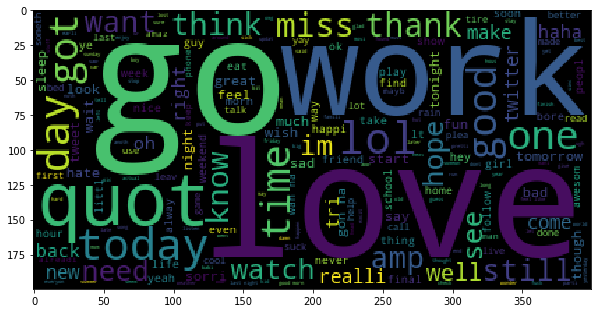

In [7]:
# your code here
tweets_bag_words = [word for item in list_words for word in item]
# create words plot!
wordcloud = WordCloud().generate(" ".join(tweets_bag_words))
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)

In [8]:
fdist = FreqDist(tweets_bag_words)
fdist5000 = [k for k,v in sorted(fdist.items(), key=lambda item: item[1],reverse=True)[:5000]]

In [9]:
# make new column in pandas filtering fdist5000 words only
def meaningful_words(token_words,relevant_words):
    return ' '.join([word for word in token_words if word in relevant_words])

tweets_sample['important_text'] = tweets_sample.text_processed.apply(meaningful_words,relevant_words=fdist5000)


### Building Features

Now let's build the features. Using the top 5,000 words, create a 2-dimensional matrix to record whether each of those words is contained in each document (tweet). Then you also have an output column to indicate whether the sentiment in each tweet is positive. For example, assuming your bag of words has 5 items (`['one', 'two', 'three', 'four', 'five']`) out of 4 documents (`['A', 'B', 'C', 'D']`), your feature set is essentially:

| Doc | one | two | three | four | five | is_positive |
|---|---|---|---|---|---|---|
| A | True | False | False | True | False | True |
| B | False | False | False | True | True | False |
| C | False | True | False | False | False | True |
| D | True | False | False | False | True | False|

However, because the `nltk.NaiveBayesClassifier.train` class we will use in the next step does not work with Pandas dataframe, the structure of your feature set should be converted to the Python list looking like below:

```python
[
	({
		'one': True,
		'two': False,
		'three': False,
		'four': True,
		'five': False
	}, True),
	({
		'one': False,
		'two': False,
		'three': False,
		'four': True,
		'five': True
	}, False),
	({
		'one': False,
		'two': True,
		'three': False,
		'four': False,
		'five': False
	}, True),
	({
		'one': True,
		'two': False,
		'three': False,
		'four': False,
		'five': True
	}, False)
]
```

To help you in this step, watch the [following video](https://www.youtube.com/watch?v=-vVskDsHcVc) to learn how to build the feature set with Python and NLTK. The source code in this video can be found [here](https://pythonprogramming.net/words-as-features-nltk-tutorial/).

[![Building Features](../images/building-features.jpg)](https://www.youtube.com/watch?v=-vVskDsHcVc)

In [10]:
# your code here
# I will prepare the model using sklearn functions
# I will fit the model to a logistic regression problem using sklearn
vectorizer = CountVectorizer()
x = tweets_sample.important_text
vector = vectorizer.fit(x)
X = vector.transform(x)

### Building and Traininng Naive Bayes Model

In this step you will split your feature set into a training and a test set. Then you will create a Bayes classifier instance using `nltk.NaiveBayesClassifier.train` ([example](https://www.nltk.org/book/ch06.html)) to train with the training dataset.

After training the model, call `classifier.show_most_informative_features()` to inspect the most important features. The output will look like:

```
Most Informative Features
	    snow = True            False : True   =     34.3 : 1.0
	  easter = True            False : True   =     26.2 : 1.0
	 headach = True            False : True   =     20.9 : 1.0
	    argh = True            False : True   =     17.6 : 1.0
	unfortun = True            False : True   =     16.9 : 1.0
	    jona = True             True : False  =     16.2 : 1.0
	     ach = True            False : True   =     14.9 : 1.0
	     sad = True            False : True   =     13.0 : 1.0
	  parent = True            False : True   =     12.9 : 1.0
	  spring = True            False : True   =     12.7 : 1.0
```

The [following video](https://www.youtube.com/watch?v=rISOsUaTrO4) will help you complete this step. The source code in this video can be found [here](https://pythonprogramming.net/naive-bayes-classifier-nltk-tutorial/).

[![Building and Training NB](../images/nb-model-building.jpg)](https://www.youtube.com/watch?v=rISOsUaTrO4)

In [11]:
# your code here

X_train, X_test, y_train, y_test = train_test_split(X, tweets_sample.target, test_size=0.2, random_state=42)

# I will use a logistic regression model from sklearn
# For that reason, I will scale my data

# I am going for the full model (for large models I should keep the sparsity)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.toarray())

clf = LogisticRegression(multi_class='ovr').fit(X_train_scaled, y_train)


C:\Users\beto\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Testing Naive Bayes Model

Now we'll test our classifier with the test dataset. This is done by calling `nltk.classify.accuracy(classifier, test)`.

As mentioned in one of the tutorial videos, a Naive Bayes model is considered OK if your accuracy score is over 0.6. If your accuracy score is over 0.7, you've done a great job!

In [12]:
# your code here

# test the logistic regression model
X_test_scaled = scaler.transform(X_test.toarray())
y_pred = clf.predict(X_test_scaled)

# mean accuracy on the given test data and labels
print(f"Accuracy score: {clf.score(X_test_scaled, y_test)}")

# c_00: true negative c_10: false negatives c_11: true positives c_01 false positive
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")



Accuracy score: 0.673
Confusion matrix:
[[1333  654]
 [ 654 1359]]


## Bonus Question 1: Improve Model Performance

If you are still not exhausted so far and want to dig deeper, try to improve your classifier performance. There are many aspects you can dig into, for example:

* Improve stemming and lemmatization. Inspect your bag of words and the most important features. Are there any words you should furuther remove from analysis? You can append these words to further remove to the stop words list.

* Remember we only used the top 5,000 features to build model? Try using different numbers of top features. The bottom line is to use as few features as you can without compromising your model performance. The fewer features you select into your model, the faster your model is trained. Then you can use a larger sample size to improve your model accuracy score.

In [13]:
# your code here

## Bonus Question 2: Machine Learning Pipeline

In a new Jupyter Notebook, combine all your codes into a function (or a class). Your new function will execute the complete machine learning pipeline job by receiving the dataset location and output the classifier. This will allow you to use your function to predict the sentiment of any tweet in real time. 

In [14]:
# your code here

## Bonus Question 3: Apache Spark

If you have completed the Apache Spark advanced topic lab, what you can do is to migrate your pipeline from local to a Databricks Notebook. Share your notebook with your instructor and classmates to show off your achievements!

In [15]:
# your code here